In [15]:
import numpy as np
import torch
from torch_geometric.utils.convert import from_networkx
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
import math
import networkx as nx
import pandas as pd
import ast
import torch
import torch_geometric
import os
from tqdm import tqdm
import torch.nn.functional as F
from torch.nn import Embedding, Linear, ModuleList, ReLU, Sequential,Dropout, Sigmoid
from torch_geometric.nn import BatchNorm, PNAConv, global_add_pool
from torch_geometric.utils import degree
import shutil
import random
from PNA_model import PNA_Net

#Load Data for GNN

In [16]:
import argparse
from graph_dataset import GraphDataset, split_data, EarlyStopping

def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--seed", required=False, default=1871, type=int, help="seed number")
    parser.add_argument("--path", required=False, default='/Downloads/All-Terminal-Reliability/GNN/data/', type=str, help="path to the data folder")
    parser.add_argument("--train_portion", required=False, default=0.75, type=float, help="train proportion")
    parser.add_argument("--valid_portion", required=False, default=0.15, type=float, help="validation proportion")
    parser.add_argument("--batch_size", default=64, type = int, help="batch size")
    parser.add_argument("--lr", default=0.001, type=float, help="learning rate")
    parser.add_argument("--weight_decay", default=0.1, type=float, help="weight decay for optimizer")
    parser.add_argument("--es_episodes", default=70, type = int, help="number of episodes that early stopping should wait")
    parser.add_argument("--es_improvement", default=0, type=float, help="the amount of improvement that each episode of early stopping will look for")
    parser.add_argument("--epochs", default=300, type = int, help="number of epochs")
    

    #parser.add_argument("--u_bound", default=0.6, type=float, help="edge addition upper bound")
    #parser.add_argument("--path", default='reliability_tdzdd/', type=str, help="path to the folder")
    ################
    parser.add_argument("--f", required=False)
    args = parser.parse_args()
    #args = parser.parse_args()
    #################
    return args

In [17]:
args = get_args()

#Train GNN

In [22]:
def train(args):
    
    train_losses = []
    validation_losses = []

    ### Reading the dataset and convert it to dataloader ready for GNN
    train, valid, test = split_data(args)
    train_loader = DataLoader(train, batch_size=args.batch_size, shuffle=True)
    test_loader = DataLoader(test, batch_size=args.batch_size, shuffle=True)
    valid_loader = DataLoader(valid, batch_size=args.batch_size, shuffle=True)

    model = PNA_Net(train)

    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay= args.weight_decay)
    criterion = torch.nn.MSELoss(reduction = 'sum')
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                       eta_min = 0.001,
                                                       T_max = 1000)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    es = EarlyStopping(args.es_episodes, args.es_improvement)

    def train():
        model.train()

        total_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out, embed = model(data.x.to(device),
                        data.edge_index.type(torch.LongTensor).to(device),
                        data.edge_attr.type(torch.LongTensor).to(device),
                        data.batch.squeeze().to(device))
            loss = criterion(out.squeeze().to(device), data.y.to(device))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss/len(train_loader.sampler)


    @torch.no_grad()
    def test(loader):
        model.eval()

        total_error = 0
        for data in loader:
            data = data.to(device)
            out, embed = model(data.x.to(device),
                        data.edge_index.type(torch.LongTensor).to(device),
                        data.edge_attr.type(torch.LongTensor).to(device),
                        data.batch.squeeze().to(device))
            loss_test = criterion(out.squeeze().to(device), data.y.to(device))
            total_error += loss_test.item()
        return loss_test, total_error/len(loader.sampler)

    train_losses = []
    test_losses = []
    for epoch in range(1, args.epochs+1):
        loss = train()
        test_epoch_mse ,test_mse = test(valid_loader)
        train_losses.append(loss)
        test_losses.append(test_mse)
        scheduler.step()
        if es(model, test_epoch_mse):
            print(f'Epoch: {epoch} \t Train_Loss: {loss:.4f} \t Test_Loss: {test_mse:.4f} \t EStop:[{es.status}]')
            break
        else:
            print(f'Epoch: {epoch} \t Train_Loss: {loss:.4f} \t Test_Loss: {test_mse:.4f} \t EStop:[{es.status}]')

In [23]:
if __name__ == "__main__":
    train(args)

Processing...
100%|██████████| 2000/2000 [00:01<00:00, 1173.33it/s]
Done!
Processing...
100%|██████████| 2000/2000 [00:01<00:00, 1092.82it/s]
Done!
/Users/farid/Downloads/All-Terminal-Reliability/GNN/graph_dataset.py:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the load

Epoch: 1 	 Train_Loss: 0.0083 	 Test_Loss: 0.0241 	 EStop:[0/70]


In [128]:
def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out, embed = model(data.x.to(device),
                    data.edge_index.type(torch.LongTensor).to(device),
                    data.edge_attr.type(torch.LongTensor).to(device),
                    data.batch.squeeze().to(device))
        loss = criterion(out.squeeze().to(device), data.y.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss/len(train_loader.sampler)


@torch.no_grad()
def test(loader):
    model.eval()

    total_error = 0
    for data in loader:
        data = data.to(device)
        out, embed = model(data.x.to(device),
                    data.edge_index.type(torch.LongTensor).to(device),
                    data.edge_attr.type(torch.LongTensor).to(device),
                    data.batch.squeeze().to(device))
        loss_test = criterion(out.squeeze().to(device), data.y.to(device))
        total_error += loss_test.item()
    return loss_test, total_error/len(loader.sampler)

train_losses = []
test_losses = []
for epoch in range(1, 351):
    loss = train()
    test_epoch_mse ,test_mse = test(valid_loader)
    train_losses.append(loss)
    test_losses.append(test_mse)
    scheduler.step()
    if es(model, test_epoch_mse):
        print(f'Epoch: {epoch} \t Train_Loss: {loss:.4f} \t Test_Loss: {test_mse:.4f} \t EStop:[{es.status}]')
        break
    else:
        print(f'Epoch: {epoch} \t Train_Loss: {loss:.4f} \t Test_Loss: {test_mse:.4f} \t EStop:[{es.status}]')

/Users/farid/Downloads/All-Terminal-Reliability/GNN/graph_dataset.py:186: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.processed_dir,


Epoch: 1 	 Train_Loss: 0.0076 	 Test_Loss: 0.0050 	 EStop:[0/70]


KeyboardInterrupt: 

#Model Performance

In [ ]:
ssq = torch.nn.MSELoss(reduction = 'sum')

In [ ]:
running_loss_train = 0.0
for element in train_loader:
    element.to(device)
    with torch.no_grad():
        out, embed = model(element.x.cuda(),
                    element.edge_index.type(torch.LongTensor).cuda(),
               element.edge_attr.type(torch.LongTensor).cuda(),element.batch.squeeze().cuda())
        loss = ssq(out.squeeze(), element.y)
        running_loss_train += loss.item()
    mse = running_loss_train/len(train_loader.sampler)
print("Loss: %.6f \t RMSE: %.6f"%(mse,mse**0.5))

Loss: 0.000016 	 RMSE: 0.004001


In [ ]:
running_loss_valid = 0.0
for element in valid_loader:
    model.eval()
    element.to(device)
    with torch.no_grad():
        out, embed = model(element.x.cuda(),
                    element.edge_index.type(torch.LongTensor).cuda(),
               element.edge_attr.type(torch.LongTensor).cuda(),element.batch.squeeze().cuda())
        loss = ssq(out.squeeze(), element.y)
        running_loss_valid += loss.item()
    mse = running_loss_valid/len(valid_loader.sampler)
print("Loss: %.6f \t RMSE: %.6f"%(mse,mse**0.5))

Loss: 0.000170 	 RMSE: 0.013027


In [ ]:
running_loss_test = 0.0
for element in test_loader:
    model.eval()
    element.to(device)
    with torch.no_grad():
        out, embed = model(element.x.cuda(),
                    element.edge_index.type(torch.LongTensor).cuda(),
               element.edge_attr.type(torch.LongTensor).cuda(),element.batch.squeeze().cuda())
        loss = ssq(out.squeeze(), element.y)
        running_loss_test += loss.item()
    mse = running_loss_test/len(test_loader.sampler)
print("Loss: %.6f \t RMSE: %.6f"%(mse,mse**0.5))

Loss: 0.000130 	 RMSE: 0.011396


In [ ]:
#df_loss = pd.read_csv('losses_sigmoid_2023-12-21.csv')

In [ ]:
#df_loss.shape

<Axes: title={'center': 'Losses of Train and Validation Sets'}, xlabel='Epochs', ylabel='Loss'>

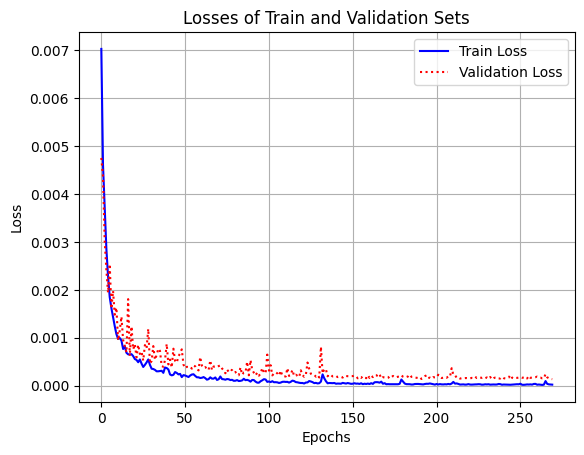

In [ ]:
# Visualize learning (training loss)
import seaborn as sns
train_losses_float = [loss for loss in train_losses]
train_loss_indices = [i for i,l in enumerate(train_losses_float)]

test_losses_float = [loss for loss in test_losses]
test_loss_indices = [i for i,l in enumerate(test_losses_float)]

plt = sns.lineplot(x = train_loss_indices, y = train_losses_float, color='b', label='Train Loss')
plt = sns.lineplot(x = test_loss_indices , y = test_losses_float, color= 'r', label= 'Validation Loss', linestyle=':')
plt.legend()
plt.set(xlabel='Epochs', ylabel='Loss', title='Losses of Train and Validation Sets')
plt.grid('on')
plt

In [ ]:
reliability_ = []
for i in test_dataset:
  reliability_.append(i.y.item())

df_ordered = pd.DataFrame(reliability_, columns=['reliability']).sort_values('reliability')
ordered_index = list(df_ordered.index)

data_list = []
for i in range(len(ordered_index)):
  data_list.append(test_dataset[ordered_index[i]])

#from torch_geometric.loader import DataLoader
new_train_loader = DataLoader(data_list, batch_size=64, shuffle=False)

prediction = []
for element in new_train_loader:
    element.to(device)
    with torch.no_grad():
        out, embed = model(element.x.cuda(),
                    element.edge_index.type(torch.LongTensor).cuda(),
               element.edge_attr.type(torch.LongTensor).cuda(),element.batch.squeeze().cuda())
        for j in out:
          prediction.append(j.item())


df_ordered['prediction'] = prediction
df_ordered.reset_index(inplace = True, drop = True)

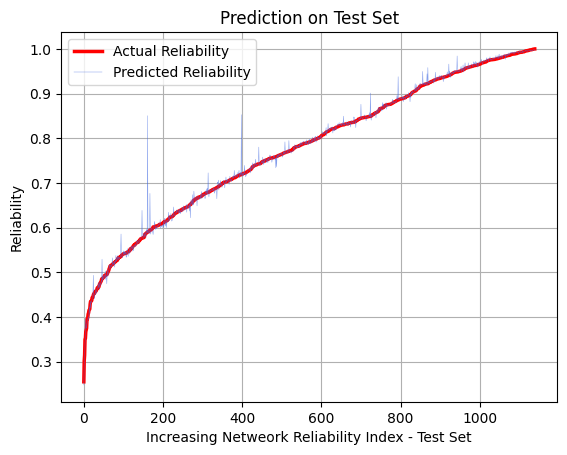

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df_ordered.index, df_ordered.reliability.values, color='red', label='Actual Reliability', linewidth=2.5,)
plt.plot(df_ordered.index, df_ordered.prediction.values, color='royalblue',linewidth=0.35,label='Predicted Reliability',alpha=0.65)
plt.grid(True)
plt.xlabel('Increasing Netweork Reliability Index - Test Set')
plt.ylabel('Reliability')
plt.title('Prediction on Test Set')
plt.legend()
plt.show()

In [ ]:
plt.figure.savefig('loss_sigmoid.jpg')

#Save Model

In [ ]:
_epochs = [i for i in range(len(train_losses))]
df_losses = pd.DataFrame(list(zip(_epochs, train_losses, test_losses)),
                            columns=['epoch', 'train_loss', 'test_loss'])
df_losses.to_csv('losses_sigmoid_2024-01-10.csv')

In [ ]:
torch.save(model, 'model_sigmoid_2024-01-10.pth')
#model = torch.load('model_sigmoid_2023-12-21.pth', map_location = "cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
while True:
  pass

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-43-648a2bab0435>", line 1, in <cell line: 1>
    while True:
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 248, in 

#New Data for GNN

In [ ]:
def predict(new_graph, reliability, model, path):

  #path = '/content/drive/MyDrive/RAMS2024_ATNR/data/'

  os.chdir(path)
  model = torch.load('model.pth', map_location = "cuda:0" if torch.cuda.is_available() else "cpu")
  graph_to_dict = nx.to_dict_of_dicts(new_graph)
  sample_graph_df = pd.DataFrame([[graph_to_dict, reliability]], columns=['graphs', 'reliability'])
  sample_graph_df.to_csv('raw/sample_graphs.csv')
  shutil.rmtree(path+'processed')
  os.mkdir(path+'processed')
  sample_dset = GraphDataset('.', 'sample_graphs.csv')
  sample_loader = DataLoader(sample_dset, batch_size=1, shuffle=False)
  sample = next(iter(sample_loader))
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  sample.to(device)
  with torch.no_grad():
    out, embed = model(sample.x.cuda(),
                      sample.edge_index.type(torch.LongTensor).cuda(),
                      sample.edge_attr.type(torch.LongTensor).cuda(),
                      sample.batch.squeeze().cuda())
  return float(out)

In [ ]:
#sample "https://link.springer.com/chapter/10.1007/978-3-030-29035-1_11"

g1 = nx.Graph()
g1.add_nodes_from(range(0, 14))
g1.add_edge(0,1)
g1.add_edge(0,2)
g1.add_edge(0,3)
g1.add_edge(1,3)
g1.add_edge(1,9)
g1.add_edge(1,13)
g1.add_edge(2,4)
g1.add_edge(2,6)
g1.add_edge(2,7)
g1.add_edge(2,9)
g1.add_edge(3,4)
g1.add_edge(3,5)
g1.add_edge(3,9)
g1.add_edge(3,13)
g1.add_edge(4,5)
g1.add_edge(5,9)
g1.add_edge(5,10)
g1.add_edge(6,7)
g1.add_edge(6,9)
g1.add_edge(6,10)
g1.add_edge(6,11)
g1.add_edge(6,12)
g1.add_edge(7,8)
g1.add_edge(9,11)
g1.add_edge(9,12)
g1.add_edge(11,12)
for i in g1.edges():
    nx.set_edge_attributes(g1, {i : {"reliability": 0.8}})

#graph_to_dict = nx.to_dict_of_dicts(g)
reliability1 = 0.6793140512072846

In [ ]:
#sample 2 "https://link.springer.com/chapter/10.1007/978-3-319-98557-2_29"
g2 = nx.Graph()
g2.add_nodes_from(range(0, 13))
#g.add_edge(0,1, reliability = 0.619)
g2.add_edge(0,1, reliability = 0.905)
g2.add_edge(0,4, reliability = 0.949)
g2.add_edge(0,5, reliability = 0.916)
g2.add_edge(1,2, reliability = 0.739)
g2.add_edge(2,3, reliability = 0.502)
g2.add_edge(2,7, reliability = 0.735)
g2.add_edge(3,4, reliability = 0.939)
g2.add_edge(3,5, reliability = 0.847)
g2.add_edge(3,6, reliability = 0.83)
g2.add_edge(4,7, reliability = 0.875)
g2.add_edge(5,6, reliability = 0.504)
g2.add_edge(5,7, reliability = 0.669)
g2.add_edge(5,8, reliability = 0.62)
g2.add_edge(7,8, reliability = 0.664)
#g.add_edge(7,9, reliability = 0.968)
#g.add_edge(7,10, reliability = 0.808)
#g.add_edge(8,12, reliability = 0.54)
#g.add_edge(7,11, reliability = 0.975)

#graph_to_dict = nx.to_dict_of_dicts(g2)
reliability2 = 0.7356004334442897

In [ ]:
path = '/content/drive/MyDrive/RAMS2024_ATNR/data/'
x = predict(g2, reliability2, model, path)

Processing...
100%|██████████| 1/1 [00:00<00:00, 112.94it/s]
Done!


In [ ]:
print('actual {} vs. predicted {}'.format(reliability2, x))

actual 0.7356004334442897 vs. predicted 0.8140411972999573
